In [1]:
%matplotlib inline
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import scipy.io
from tensorflow.python.framework import function

import os, re

import claude.utils as cu
import claude.claudeflow.autoencoder as ae
import claude.claudeflow.helper as cfh

In [2]:
# Parameters
# Channel Parameters
chParam = cu.AttrDict()
chParam.M = 16
chParam.w = int(np.log2(chParam.M))
if chParam.M == 16:
    chParam.SNR = 10
elif chParam.M == 64:
    chParam.SNR = 18
else:
    chParam.SNR = 22

# Auto-Encoder Parameters
aeParam = cu.AttrDict()
aeParam.seed = 1337
aeParam.dimension	= 2
aeParam.nLayers		= 4
aeParam.hiddenUnits	= 256
aeParam.activation  = tf.nn.relu
aeParam.dropout		= False
aeParam.dtype       = tf.float32

# Training Parameters
trainingParam = cu.AttrDict()
trainingParam.sampleSize	= 16*chParam.M # Increase for better results (especially if M>16)
trainingParam.batchSize 	= 1*chParam.M  # Increase for better results (especially if M>16)
trainingParam.learningRate	= 0.001
trainingParam.displayStep	= 25
trainingParam.path			= 'results_GMI_AWGN'
trainingParam.filename		= 'M{:03d}_seed{:04d}_SNR{:02d}'.format(chParam.M,aeParam.seed,chParam.SNR)
trainingParam.earlyStopping = 25
trainingParam.iterations = 500
trainingParam.summaries = True

if trainingParam.summaries:
    # tensorboard directory
    chHyperParam = ['M','SNR']
    aeHyperParam = ['seed']
    trainingHyperParam = []

    trainingParam.summaryString = ','.join(  [ '{}={}'.format(item,chParam[item]) for item in chHyperParam ]
                                            +[ '{}={}'.format(item,trainingParam[item]) for item in trainingHyperParam ]
                                            +[ '{}={}'.format(item,aeParam[item]) for item in aeHyperParam ] )

    print(trainingParam.summaryString,flush=True)

M=16,SNR=10,seed=1337


In [3]:
# TF constants
one = tf.constant(1,aeParam.dtype)
two = tf.constant(2,aeParam.dtype)
DIM = tf.constant(aeParam.dimension,aeParam.dtype)
PI = tf.constant(np.pi,aeParam.dtype)

## Comment on the following cell:
When normalizing the constellation after the encoder, tensorflow has trouble to differentiate `tf.norm` with its autodiff. Instead we overwrite the autodiff with the analytical gradient of the specific norm we are using. 

In [4]:
# Normalization instability fix
@function.Defun(aeParam.dtype, aeParam.dtype)
def norm_grad(x, dy):
    return dy*(x/(tf.norm(x)+1.0e-19))

@function.Defun(aeParam.dtype, grad_func=norm_grad)
def norm(x):
    return tf.norm(x)

def IQ_norm(enc_seed,epsilon=1e-12):
    normHack = tf.stack([ norm(tf.squeeze(x)) for x in tf.split(enc_seed,num_or_size_splits=chParam.M)])
    rmean = tf.reduce_mean( tf.square( normHack ) )
    rsqrt = tf.rsqrt(tf.maximum(rmean, epsilon))    
    return rsqrt

In [5]:
tf.set_random_seed(aeParam.seed)
np.random.seed(aeParam.seed)

# Tx Graph
allCombinations = cu.generateUniqueBitVectors(chParam.M)
X = tf.placeholder( aeParam.dtype, shape=(None, chParam.w) )
X_seed = tf.constant( allCombinations, aeParam.dtype )

In [6]:
enc = ae.encoder(X,aeParam.hiddenUnits,aeParam.nLayers,aeParam.activation,nOutput=aeParam.dimension)
enc_seed = ae.encoder(X_seed,aeParam.hiddenUnits,aeParam.nLayers,aeParam.activation,nOutput=aeParam.dimension)

In [7]:
norm_factor = IQ_norm(enc_seed)
enc_norm = norm_factor*enc
enc_seed_norm = norm_factor*enc_seed

Instructions for updating:
Shapes are always computed; don't use the compute_shapes as it has no effect.


In [8]:
# Channel Graph
SNR_lin = cfh.dB2lin(tf.constant(chParam.SNR,aeParam.dtype),'dB')
sigma2_noise = one / SNR_lin
noise = tf.sqrt(sigma2_noise) * tf.rsqrt(two) * tf.random_normal(shape=tf.shape(enc_norm),dtype=aeParam.dtype)
channel = enc_norm + noise

In [9]:
# Rx Graph
decoder = ae.decoder(channel, aeParam.hiddenUnits, aeParam.nLayers, aeParam.activation, chParam.w)
decoder_sigmoid = tf.sigmoid(decoder)

In [10]:
# Neural Network GMI metric
# the output of the neural network with sigmoid activation can serve as an LLR estimation :)
# we basically assume that the decoder neural network has learned a probability distribution of the channel
# which we use as auxiliary channel within the receiver
sigmoid_LLRs = tf.linalg.transpose( tf.log( (one-decoder_sigmoid) / decoder_sigmoid ) )
sigmoid_GMI = cfh.GMI( tf.linalg.transpose(X), sigmoid_LLRs )

# Gaussian GMI metric
# here we just use a Gaussian auxiliary channel assumption
constellation = tf.expand_dims( tf.complex( enc_seed_norm[:,0], enc_seed_norm[:,1]), axis=0 )
channel_complex = tf.expand_dims( tf.complex( channel[:,0], channel[:,1]), axis=0 )
gaussian_LLRs = cfh.gaussianLLR( constellation, tf.linalg.transpose(X_seed), channel_complex, SNR_lin, chParam.M )
gaussian_GMI = cfh.GMI( tf.linalg.transpose(X), gaussian_LLRs )

# In this script, the channel is a Gaussian channel, so a Gaussian auxiliary channel assumption is optimal
# Therefore: Gaussian GMI > Neural Network GMI

In [12]:
# bit errors and ber
input_bits = tf.cast( X , tf.int32 )
output_bits = tf.cast( tf.round( tf.nn.sigmoid( decoder ) ), tf.int32 )
bit_compare = tf.not_equal( output_bits, input_bits )
bit_errors = tf.reduce_sum( tf.cast( bit_compare, tf.int32 ) ) 
bit_error_rate = tf.reduce_mean( tf.cast( bit_compare, aeParam.dtype ) )

In [14]:
# loss
loss = tf.reduce_mean( tf.nn.sigmoid_cross_entropy_with_logits( labels=X, logits=decoder ) )
optimizer = tf.train.AdamOptimizer(learning_rate=trainingParam.learningRate)
d_sigmoid_loss = optimizer.minimize(loss)

# avg_metric_reset: set to zero
# avg_metric_update: add recent value to variable
# avg_metric: get average of sum'd variables
avg_loss, avg_loss_update, avg_loss_reset = cfh.create_reset_metric(tf.metrics.mean, 'loss_metric', loss)
avg_ber, avg_ber_update, avg_ber_reset = cfh.create_reset_metric(tf.metrics.mean, 'ber_metric', bit_error_rate)
avg_gaussian_gmi, avg_gaussian_gmi_update, avg_gaussian_gmi_reset = cfh.create_reset_metric(tf.metrics.mean, 'gaussian_gmi_metric', gaussian_GMI)
avg_sigmoid_gmi, avg_sigmoid_gmi_update, avg_sigmoid_gmi_reset = cfh.create_reset_metric(tf.metrics.mean, 'sigmoid_gmi_metric', sigmoid_GMI)
reset_ops = [avg_loss_reset, avg_ber_reset, avg_gaussian_gmi_reset, avg_sigmoid_gmi_reset]
update_ops = [avg_loss_update, avg_ber_update, avg_gaussian_gmi_update, avg_sigmoid_gmi_update]

In [15]:
sess = tf.Session()

if trainingParam.summaries:
    weights_summaries = tf.summary.merge_all() # without weight/bias histograms
    # Summaries
    s = [tf.summary.scalar('accuracy', avg_ber),
         tf.summary.scalar('loss', avg_loss),
         tf.summary.scalar('gaussian_GMI', avg_gaussian_gmi),
         tf.summary.scalar('sigmoid_GMI', avg_sigmoid_gmi)]

    epoche_summaries = tf.summary.merge(s) # without weight/bias histograms

    summaries_dir = os.path.join(trainingParam.path,'tboard{}'.format(chParam.M),trainingParam.summaryString)
    os.makedirs(summaries_dir, exist_ok=True)

    train_writer = tf.summary.FileWriter(summaries_dir + '/train', sess.graph)
else:
    train_writer = None
        
sess.run(tf.global_variables_initializer())

saver = tf.train.Saver()
checkpoint_path = os.path.join(trainingParam.path,'checkpoint',trainingParam.filename,'best')
if not os.path.exists(checkpoint_path):
    os.makedirs(checkpoint_path)
else:
    pass
#     print("Restoring checkpoint...", flush=True)
#     saver.restore(sess=sess,save_path=checkpoint_path)

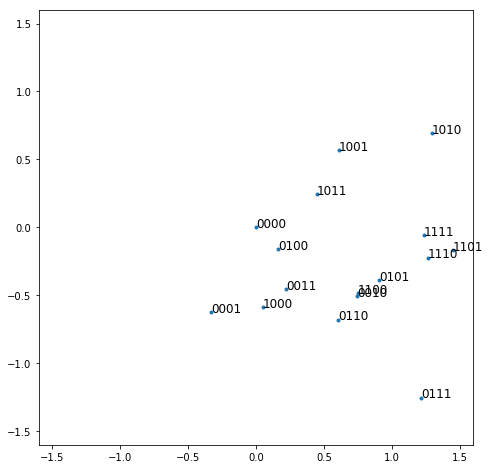

In [16]:
# constellation before training
[constellation,constellation_bits] = sess.run([enc_seed_norm,X_seed])
plt.figure(figsize=(8,8))
plt.plot(constellation[:,0],constellation[:,1],'.')

for ii in range(constellation.shape[0]):
    bit_string = ''.join( [ str(int(x)) for x in allCombinations[ii,:].tolist()] )
    plt.text(constellation[ii,0], constellation[ii,1], bit_string, fontsize=12)
plt.axis('square');
lim_ = 1.6
plt.xlim(-lim_,lim_);
plt.ylim(-lim_,lim_);

In [17]:
bestLoss = 100000
bestAcc = 0
lastImprovement = 0
epoche = 0
nBatches = int(trainingParam.sampleSize/trainingParam.batchSize)
batchSizeMultiples = 1
batchSize = batchSizeMultiples * trainingParam.batchSize

np_loss = []
np_ber  = []
np_gaussian_gmi  = []
np_sigmoid_gmi  = []

### Comment on the training procedure:
The training gets stuck early when a large batch size is chosen. For this reason we start with a low batch size, and iterativley increase it after temporary convergence. Training with a low batch size introduces a more stochastic gradient estimation, which helps to get out of the local minima.

In [18]:
print( 'START TRAINING ... ', flush=True )
while(True):
    epoche = epoche + 1

    sess.run(reset_ops)
    
    # train AE with iteratively increasing batch size
    for batch in range(0,nBatches):
        feedDict = {X: cu.generateBitVectors(batchSize,chParam.M)}
        sess.run(d_sigmoid_loss, feed_dict=feedDict)
    
    # gather performance metrics with large batch size
    for batch in range(0,nBatches):
        feedDict = {X: cu.generateBitVectors(trainingParam.sampleSize,chParam.M)}
        sess.run(update_ops, feed_dict=feedDict)

    [outAvgLoss, outAvgBer, outAvgGaussianGmi, outAvgSigmoidGmi] = sess.run([avg_loss, avg_ber, avg_gaussian_gmi, avg_sigmoid_gmi], feed_dict=feedDict)

    np_loss.append( outAvgLoss )
    np_ber.append( outAvgBer )
    np_gaussian_gmi.append( outAvgGaussianGmi )
    np_sigmoid_gmi.append( outAvgSigmoidGmi )
    
    if trainingParam.summaries:
        epocheSummaries = sess.run(epoche_summaries, feed_dict=feedDict)
        train_writer.add_summary(epocheSummaries,epoche)

    if outAvgLoss < bestLoss:
        bestLoss = outAvgLoss
        lastImprovement = epoche
        saver.save(sess=sess,save_path=checkpoint_path)

    # convergence check and increase empirical evidence
    if epoche - lastImprovement > trainingParam.earlyStopping:

        saver.restore(sess=sess,save_path=checkpoint_path)
        bestLoss = 10000
        lastImprovement = epoche

        # increase empirical evidence
        batchSizeMultiples = batchSizeMultiples + 2
        batchSize = batchSizeMultiples * trainingParam.batchSize
        if batchSizeMultiples >= 17:
            break;

        print("batchSize: {}, batchSizeMultiples: {}".format(batchSize,batchSizeMultiples))

    if epoche%trainingParam.displayStep == 0:
        print('epoche: {:04d} - avgLoss: {:.2f} - avgBer: {:.2e} - avgGaussianGmi: {:.2f} - avgSigmoidGmi: {:.2f}'.format(epoche,outAvgLoss,outAvgBer,outAvgGaussianGmi,outAvgSigmoidGmi),flush=True)

START TRAINING ... 
epoche: 0025 - avgLoss: 0.23 - avgBer: 1.10e-01 - avgGaussianGmi: 2.97 - avgSigmoidGmi: 2.65
epoche: 0050 - avgLoss: 0.18 - avgBer: 7.21e-02 - avgGaussianGmi: 3.14 - avgSigmoidGmi: 2.98
epoche: 0075 - avgLoss: 0.17 - avgBer: 7.20e-02 - avgGaussianGmi: 3.16 - avgSigmoidGmi: 3.01
epoche: 0100 - avgLoss: 0.17 - avgBer: 7.24e-02 - avgGaussianGmi: 3.16 - avgSigmoidGmi: 3.03
INFO:tensorflow:Restoring parameters from results_GMI_AWGN/checkpoint/M016_seed1337_SNR10/best
batchSize: 48, batchSizeMultiples: 3
epoche: 0125 - avgLoss: 0.16 - avgBer: 6.52e-02 - avgGaussianGmi: 3.18 - avgSigmoidGmi: 3.09
INFO:tensorflow:Restoring parameters from results_GMI_AWGN/checkpoint/M016_seed1337_SNR10/best
batchSize: 80, batchSizeMultiples: 5
epoche: 0150 - avgLoss: 0.15 - avgBer: 6.22e-02 - avgGaussianGmi: 3.18 - avgSigmoidGmi: 3.12
epoche: 0175 - avgLoss: 0.15 - avgBer: 6.25e-02 - avgGaussianGmi: 3.20 - avgSigmoidGmi: 3.14
epoche: 0200 - avgLoss: 0.16 - avgBer: 6.05e-02 - avgGaussianGmi:

In [ ]:
saver.restore(sess=sess,save_path=checkpoint_path)
np_loss = np.array( np_loss )
np_ber  = np.array( np_ber )
np_gaussian_gmi  = np.array( np_gaussian_gmi )
np_sigmoid_gmi  = np.array( np_sigmoid_gmi )
plt.plot( np_loss )

In [ ]:
plt.plot( np_gaussian_gmi )
plt.plot( np_sigmoid_gmi )

In [ ]:
# constellation after training
[constellation,constellation_bits] = sess.run([enc_seed_norm,X_seed])
plt.figure(figsize=(8,8))
plt.plot(constellation[:,0],constellation[:,1],'x')

for ii in range(constellation.shape[0]):
    bit_string = ''.join( [ str(int(x)) for x in allCombinations[ii,:].tolist()] )
    plt.text(constellation[ii,0]+0.01, constellation[ii,1]+0.01, bit_string, fontsize=12)
plt.axis('square');
lim_ = 1.6
plt.xlim(-lim_,lim_);
plt.ylim(-lim_,lim_);

In [ ]:
sess.run(reset_ops)
for batch in range(0,100):
    feedDict = {X: cu.generateBitVectors(1000,chParam.M)}
    sess.run(update_ops, feed_dict=feedDict)
[outAvgLoss, outAvgBer, outAvgGaussianGmi, outAvgSigmoidGmi] = sess.run([avg_loss, avg_ber, avg_gaussian_gmi, avg_sigmoid_gmi], feed_dict=feedDict)
finalMetrics = { 'GaussianGMI': outAvgGaussianGmi, 'SigmoidGMI': outAvgSigmoidGmi, 'BER': outAvgBer, 'xentropy': outAvgLoss }

print( 'finalMetrics:', finalMetrics )